In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T_p = 1
L = 300
Q_threshold = 40
Q_max = 60
W_max = 500
cycles = 24
M = 3600
episodes = 1000

W_levels = np.linspace(0, W_max, 26)

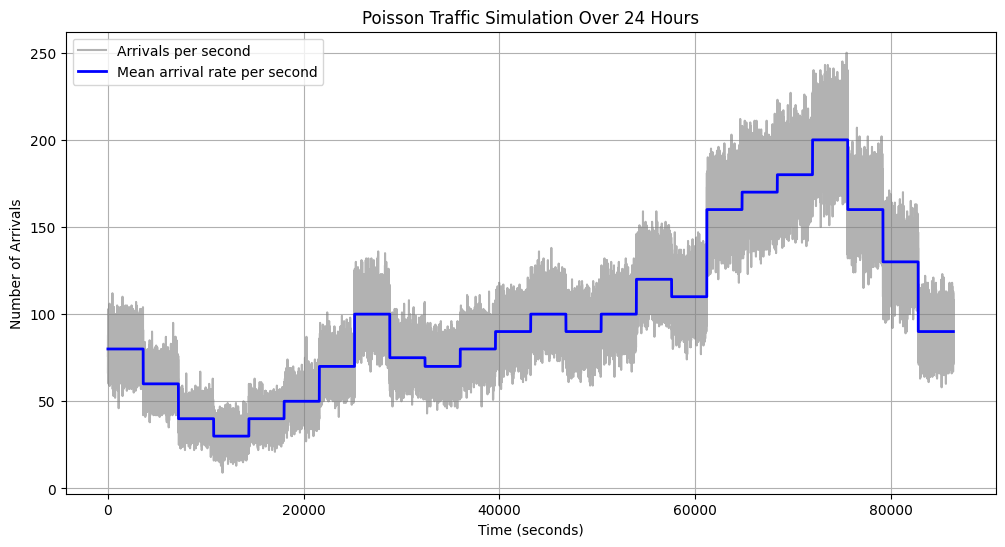

[ 76  83  73 ...  76  90 108]


In [ ]:
def generate_poisson_traffic(λ, duration):
    R = np.random.rand(int(λ * duration * 2))
    IAT = -np.log(1 - R) / λ
    arrivals = np.cumsum(IAT)
    return arrivals[arrivals <= duration]


mean_arrival_rates = np.array([80, 60, 40, 30, 40, 50, 70, 100, 75, 70, 80, 90, 100, 90, 100, 120, 110, 160, 170, 180, 200, 160, 130, 90])
total_duration = 24 * 3600
all_arrivals = []

for hour, λ in enumerate(mean_arrival_rates):
    arrivals = generate_poisson_traffic(λ, 3600)
    arrivals += hour * 3600
    all_arrivals.extend(arrivals)

all_arrivals = np.array(all_arrivals)
time_bins = np.arange(0, total_duration + 1, 1)
arrival_counts, _ = np.histogram(all_arrivals, bins=time_bins)
# print(arrival_counts)
# print(len(arrival_counts))

mean_per_second = np.repeat(mean_arrival_rates, 3600)


plt.figure(figsize=(12, 6))

plt.plot(time_bins[:-1], arrival_counts, color="gray", alpha=0.6, label="Arrivals per second")

plt.plot(time_bins[:-1], mean_per_second, color="blue", linewidth=2, label="Mean arrival rate per second")

plt.xlabel("Time (seconds)")
plt.ylabel("Number of Arrivals")
plt.title("Poisson Traffic Simulation Over 24 Hours")
plt.legend()
plt.grid()
plt.show()

print(arrival_counts)

In [ ]:
def update_queue(Q, arrivals, u, Q_max):
    new_packets=arrivals
    Q_new=Q+((new_packets-u)*T_p/L)
    return max(0,min(Q_new,Q_max+1))

In [ ]:
class LearningAgent:
    def __init__(self, n_states=3, n_actions=26, alpha=0.1, gamma=0.5, epsilon=1.0, decay=0.99):
        self.Q = np.zeros((24, n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.current_bandwidth = 0

    def choose_action(self,state,cycle):
        if np.random.rand()<self.epsilon:
            action=np.random.randint(26)
        else:
            action=np.argmax(self.Q[cycle,state])
        self.current_bandwidth=W_levels[action]
        return action

    def update_epsilon(self):
        self.epsilon*=self.decay
        return self.epsilon

    def update_sarsa(self,cycle,state,action,reward,next_state,next_action):
      if(cycle!=23):
          td_target=reward+(self.gamma*(self.Q[cycle+1,next_state,next_action]))
      else:
          td_target=reward
      self.Q[cycle,state,action]=(1-self.alpha)*self.Q[cycle,state,action]+self.alpha*td_target


    def update_qlearning(self,cycle,state,action,reward,next_state):
        if(cycle!=23):
          td_target=reward+(self.gamma*np.max(self.Q[cycle+1,next_state]))
        else:
          td_target=reward
        self.Q[cycle,state,action]=(1-self.alpha)*self.Q[cycle,state,action]+self.alpha*td_target

    def printQ(self):
        print("\n===== Q-Table =====")
        for cycle in range(24):
            print(f"\nCycle {cycle}:")
            for state in range(self.Q.shape[1]):
                print(f"  State {state}: {self.Q[cycle][state]}")
        print("\n===================")

In [ ]:
agent=LearningAgent()
qlearning_rewards=[]
qlearning_bandwidths=[]
Qlength=0

for episode in range(episodes):
  q_episode_reward=0
  q_episode_bandwidth=0

  for cycle in range(cycles):
      Q_history=[]

      if Qlength<=Q_threshold:
        state=0
      elif Qlength<Q_max:
        state=1
      else:
        state=2

      action=agent.choose_action(state,cycle)
      u=int(agent.current_bandwidth)

      for second in range(3600):
          arrivals=arrival_counts[(cycle*3600)+second]
          Qlength=update_queue(Qlength,arrivals,u,Q_max)
          Q_history.append(Qlength)

      Q_mean=np.mean(Q_history)
      p_violation=np.mean(np.array(Q_history)>=Q_threshold)
      p_drop=np.mean(np.array(Q_history)>=Q_max)

      if p_violation<=0.1 and p_drop<=0.01:
        if(episode==999):
          print(Q_mean,agent.current_bandwidth,mean_arrival_rates[cycle])
        if(agent.current_bandwidth!=0):
          reward=Q_mean+(1/agent.current_bandwidth)
        else:
          reward=Q_mean
      elif (p_violation<= 0.1 and p_drop>0.01) or (p_violation>0.1 and p_drop<=0.01):
        if(episode==999):
          print("DAMM")
        reward=0
      else:
        if(episode==999):
          print("OHH NOO")
        reward=-1

      if Qlength <= Q_threshold:
        next_state=0
      elif Qlength < Q_max:
        next_state=1
      else:
        next_state=2

      agent.update_qlearning(cycle,state,action,reward,next_state)
      q_episode_bandwidth += agent.current_bandwidth
      q_episode_reward += reward

  epsilon=agent.update_epsilon()
  qlearning_rewards.append(q_episode_reward)
  qlearning_bandwidths.append(q_episode_bandwidth)

0.40927777777777785 80.0 80
0.19930277777777786 60.0 60
0.7910648148148168 40.0 40
0.0 420.0 30
0.21783796296296304 40.0 40
0.002298148148148148 60.0 50
3.7037037037037037e-06 100.0 70
0.9335981481481463 100.0 100
0.011803703703703705 80.0 75
0.0022638888888888886 80.0 70
0.26258796296296316 80.0 80
OHH NOO
7.6863018518518444 120.0 100
1.1111111111111112e-05 120.0 90
0.6622407407407407 100.0 100
0.8563453703703696 120.0 120
0.0008851851851851834 160.0 110
0.38234537037037025 160.0 160
0.00012500000000000006 380.0 170
3.440528703703707 180.0 180
7.751065740740749 200.0 200
7.360460185185254 160.0 160
0.15150185185185588 140.0 130
1.2962962962962964e-05 120.0 90


In [ ]:
  print(q_episode_bandwidth,q_episode_reward)

3140.0 30.35999057365644


In [ ]:
sarsa=LearningAgent()
sarsa_rewards=[]
sarsa_bandwidths=[]
Qlength=0

for episode in range(episodes):
  s_episode_reward=0
  s_episode_bandwidth=0
  action=sarsa.choose_action(state,cycle)

  for cycle in range(cycles):
      Q_history=[]

      if Qlength<=Q_threshold:
        state=0
      elif Qlength<Q_max:
        state=1
      else:
        state=2

      u=int(sarsa.current_bandwidth)

      for second in range(3600):
          arrivals=arrival_counts[(cycle*3600)+second]
          Qlength=update_queue(Qlength,arrivals,u,Q_max)
          Q_history.append(Qlength)

      Q_mean=np.mean(Q_history)
      p_violation=np.mean(np.array(Q_history)>=Q_threshold)
      p_drop=np.mean(np.array(Q_history)>=Q_max)

      if p_violation<=0.1 and p_drop<=0.01:
        if(episode==999):
          print(Q_mean,sarsa.current_bandwidth,mean_arrival_rates[cycle])
        if(sarsa.current_bandwidth!=0):
          reward=Q_mean+(1/sarsa.current_bandwidth)
        else:
          reward=Q_mean
      elif (p_violation<= 0.1 and p_drop>0.01) or (p_violation>0.1 and p_drop<=0.01):
        if(episode==999):
          print("DAMM")
        reward=0
      else:
        if(episode==999):
          print("OHH NOO")
        reward=-1

      if Qlength<=Q_threshold:
        next_state=0
      elif Qlength<Q_max:
        next_state=1
      else:
        next_state=2

      s_episode_bandwidth+=sarsa.current_bandwidth
      s_episode_reward+=reward
      next_action=sarsa.choose_action(next_state,(cycle+1)%24)
      sarsa.update_sarsa(cycle,state,action,reward,next_state,next_action)
      action=next_action

  epsilon=sarsa.update_epsilon()
  sarsa_rewards.append(s_episode_reward)
  sarsa_bandwidths.append(s_episode_bandwidth)

0.00014444444444444444 100.0 80
0.19927037037037043 60.0 60
0.7910648148148168 40.0 40
0.001718518518518518 40.0 30
0.21783796296296304 40.0 40
0.002298148148148148 60.0 50
0.0 120.0 70
OHH NOO
6.221991666666655 100.0 75
0.0 240.0 70
0.26258796296296316 80.0 80
0.0 380.0 90
1.551613888888886 100.0 100
0.01757777777777772 100.0 90
0.6622407407407407 100.0 100
2.7777777777779037e-06 340.0 120
0.0 500.0 110
0.38234537037037025 160.0 160
0.00021759259259259266 320.0 170
3.440528703703707 180.0 180
7.751065740740749 200.0 200
7.360460185185254 160.0 160
0.15150185185185588 140.0 130
0.004416666666666667 100.0 90


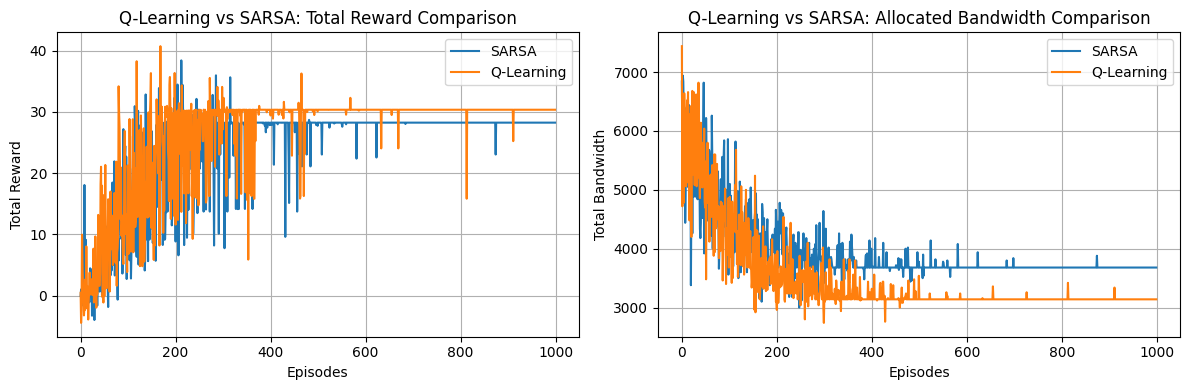

In [ ]:
# Plot rewards
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(sarsa_rewards, label='SARSA')
plt.plot(qlearning_rewards, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q-Learning vs SARSA: Total Reward Comparison')
plt.legend()
plt.grid(True)

# Plot bandwidths
plt.subplot(1, 2, 2)
plt.plot(sarsa_bandwidths, label='SARSA')
plt.plot(qlearning_bandwidths, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Total Bandwidth')
plt.title('Q-Learning vs SARSA: Allocated Bandwidth Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(q_episode_bandwidth,q_episode_reward)
print(s_episode_bandwidth,s_episode_reward)

3140.0 30.35999057365644
3680.0 28.253114686634955
